In [1]:
from sklearn.metrics import  r2_score, mean_absolute_percentage_error
from sklearn.model_selection import  GroupShuffleSplit
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
from mpl_toolkits.axes_grid1 import make_axes_locatable

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def calculate_metrics_and_plot_for_single(y_true, y_pred, var):
    # Calculate R2, RMSE, MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print the calculated metrics
    print(f'MSE:{mse}')
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Calculate point density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # Plot y_true vs y_pred density scatter plot
    plt.figure(figsize=(8, 7))

    scatter = plt.scatter(y_true, y_pred, c=z, s=15, cmap='rainbow')

    # Create color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=17)  # Set the color bar label and fontsize
    cbar.ax.tick_params(labelsize=16)  # Set the font size for the color bar ticks

    # Plot a reference line (ideal prediction line y_true = y_pred)
    plt.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    plt.xlim(1e5, 1e12)
    plt.ylim(1e5, 1e12)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(f'Actual {var}', fontsize=17)
    plt.ylabel(f'Predicted {var}', fontsize=17)
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

    # Annotate with the metrics in the top left corner
    # metrics_text = f'R$^2$: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
    metrics_text = f'R$^2$: {r2:.4f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=14,  # Adjust the font size
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

    # plt.title('Actual vs Predicted Scatter Plot with Density', fontsize=15)
    plt.grid(True)
    plt.show()

In [3]:
def calculate_metrics_and_plot(ax, y_true, y_pred, var):
    # Calculate metrics
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    scatter = ax.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')
    
    # Reference line
    ax.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    ax.set_xlim(1e5, 1e12)
    ax.set_ylim(1e5, 1e12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'Actual {var}', fontsize=12)
    ax.set_ylabel(f'Predicted {var}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # metrics_text = f'R$^2$: {r2:.2f}'
    metrics_text = f'R$^2$: {r2:.4f}\nMAPE: {mape * 100:.2f}'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    return scatter

In [ ]:
train = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_train.csv')
test  = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_test.csv')

In [14]:
input_list = ['Temperature','RH','Bulk_DP','Num_Conc','OA', 'SO4', 'Cl', 'NH4', 'NO3']

# output_list = ['CCN_CS_0.1', 'CCN_CS_0.2','CCN_CS_0.4', 'CCN_CS_0.8', 'CCN_CS_1.0']
output_list = ['CCN_VS_0.1', 'CCN_VS_0.2', 'CCN_VS_0.4', 'CCN_VS_0.8', 'CCN_VS_1.0']


X_train = train[input_list]
X_test = test[input_list]

y_train = train[output_list]
y_test = test[output_list]

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 200, 500],
    'subsample': [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0, 0.01, 0.1, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', multi_strategy='multi_output_tree')

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("最佳超参数:", grid_search.best_params_)

In [15]:
best_params = {
    'colsample_bytree': 1.0, 
    'gamma': 0, 
    'learning_rate': 0.05, 
    'max_depth': 10, 
    'min_child_weight': 1, 
    'n_estimators': 500, 
    'reg_alpha': 0.01, 
    'reg_lambda': 0.01, 
    'subsample': 0.6}

In [16]:
# 12. 使用最佳超参数训练模型
# best_model = XGBRegressor(**grid_search.best_params_, tree_method='hist', multi_strategy='multi_output_tree')
best_model = XGBRegressor(**best_params, tree_method='hist', multi_strategy='multi_output_tree')
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
best_model.save_model(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/xgb_multi_{output_list[0][:6]}.model')

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:28:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [18]:
y_test_pred = pd.DataFrame(best_model.predict(X_test), columns=output_list)

/tmp/ipykernel_98157/2816751934.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


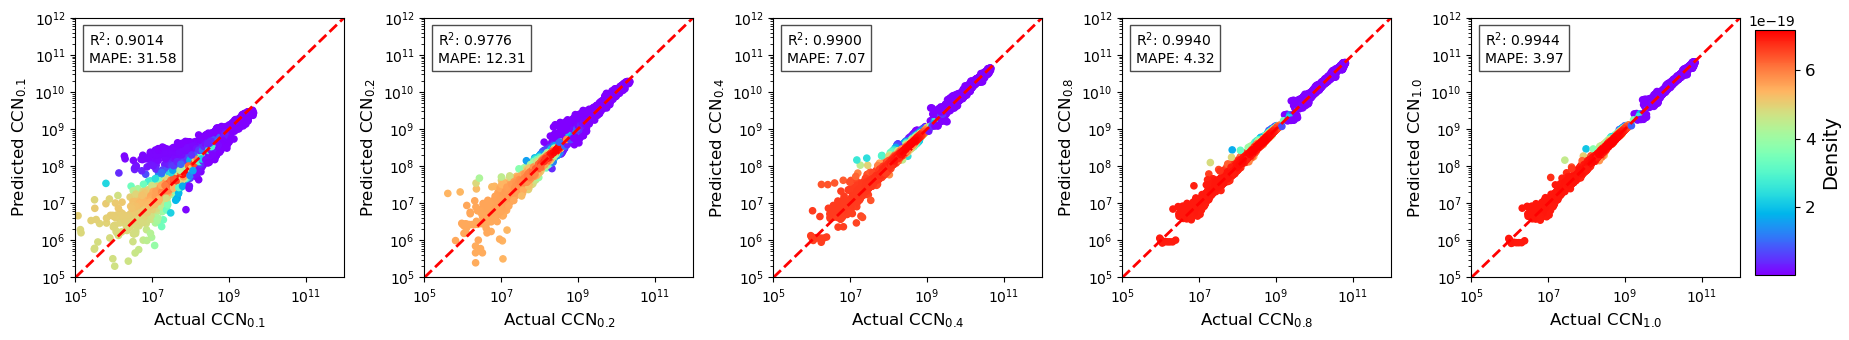

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3.5))
axes = axes.flatten()

for i, output in enumerate(output_list):
    var = f'CCN$_{{{output[7:]}}}$'
    scatter = calculate_metrics_and_plot(axes[i], y_test[output]*1e6, y_test_pred[output]*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.7])   # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()


# load model

In [2]:
model = XGBRegressor(tree_method='hist', multi_strategy='multi_output_tree')
model.load_model('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/xgb_multi.model')

In [ ]:
train = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_train.csv')
test  = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_test.csv')

input_list = ['Temperature','RH','Density','Bulk_DP','Num_Conc','SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
# output_list = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0']
output_list = ['CCN_CS_0.15', 'CCN_CS_0.4', 'CCN_CS_0.6', 'CCN_CS_1.0']

X_train = train[input_list]
X_test = test[input_list]

y_train = train[output_list]
y_test = test[output_list]

feature_names = ['T', 'RH', r'$\rm D_p$',r'$\rm N_t$','OA',r'$\rm SO_4$','NH4', 'NO3', 'Cl']

In [4]:
y_test_pred = pd.DataFrame(model.predict(X_test), columns=output_list)

/tmp/ipykernel_1719/1852779212.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


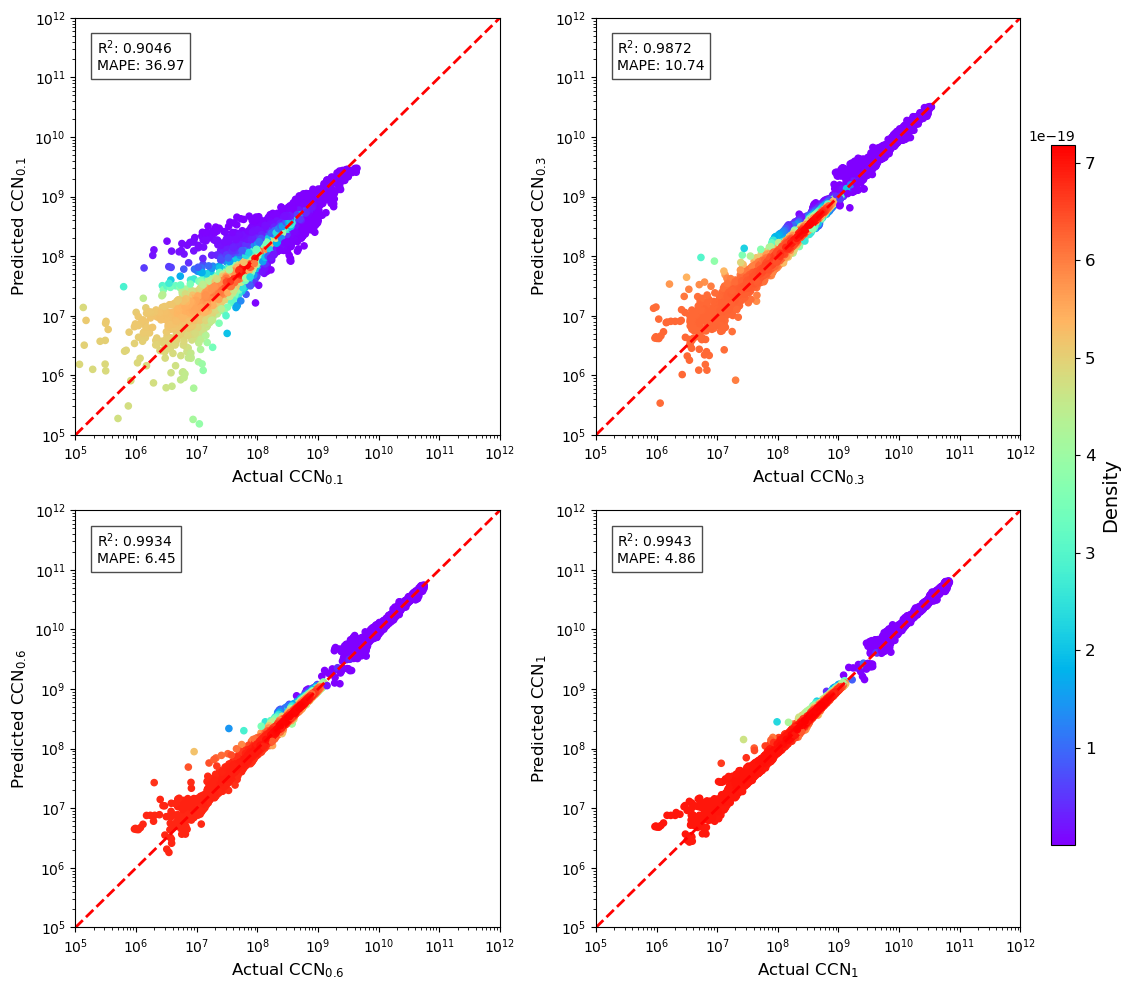

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, output in enumerate(output_list):
    if output[-2:] == '_1':
        var = f'CCN$_1$'
    else:    
        var = f'CCN$_{{{output[-2:-1]}.{output[-1:]}}}$'
        
    scatter = calculate_metrics_and_plot(axes[i], y_test[output]*1e6, y_test_pred[output]*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

In [7]:
target_idx = 3  # 0 对应 'ccn_01'

def predict_target(X):
    preds = model.predict(X)
    return preds[:, target_idx]

# 注意：此时 shap.Explainer 可能会默认使用 KernelExplainer（计算速度较慢），
explainer = shap.Explainer(predict_target, X_train)
# shap_values = explainer(X_test)

X_test_sample = X_test.sample(n=1000, random_state=42)
shap_values_sample = explainer(X_test_sample)

PermutationExplainer explainer: 1001it [01:49,  8.29it/s]                                                           


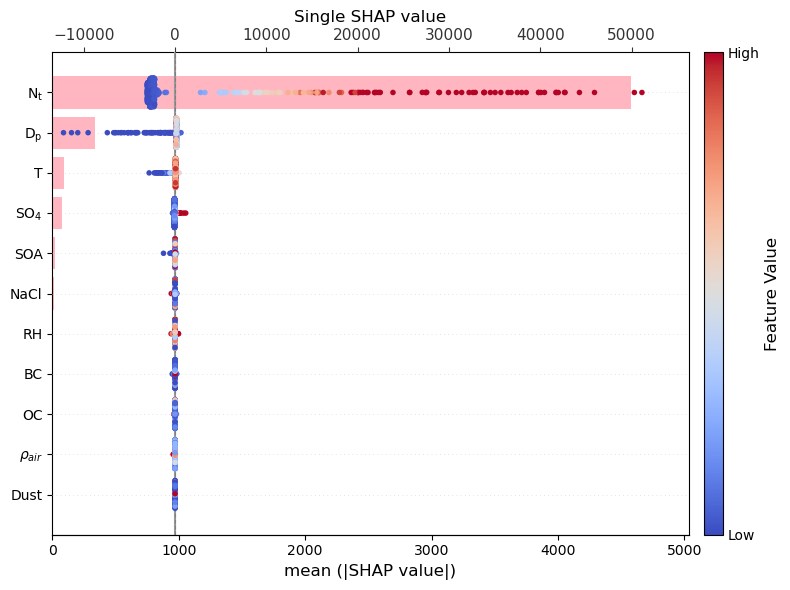

In [8]:
# 1) 计算 & 排序（降序）
shap_arr      = shap_values_sample.values
mean_abs_shap = np.abs(shap_arr).mean(axis=0)
order         = np.argsort(mean_abs_shap)[::-1]   # highest first
labels        = [feature_names[i] for i in order]

# 2) 准备倒序的 y 位置
N = len(order)
y_positions = np.arange(N)[::-1]

# 3) 重排 Explanation 对象
shap_bees = shap_values_sample[:, order]

# 4) 创建图和双 X 轴
fig, ax_bar    = plt.subplots(figsize=(8,6))
ax_scatter     = ax_bar.twiny()

# 5) 在倒序 y_positions 上画水平柱状图
ax_bar.barh(
    y_positions,
    mean_abs_shap[order],
    color='lightpink',
    edgecolor='none'
)

# 6) 在相同 y_positions 上画 beeswarm
#    beeswarm 本身会 jitter y，所以我们先画空点仅占位置：
for yi in y_positions:
    ax_scatter.plot([], [])  # 占位，不影响

shap.plots.beeswarm(
    shap_bees,
    ax=ax_scatter,
    show=False,
    plot_size=None,
    color_bar=False,
    color=plt.get_cmap("coolwarm"),
    max_display=None
)

# 7) 画上方 x=0 竖线
ax_scatter.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# 8) 设置坐标轴范围和位置
ax_bar.set_xlim(0, mean_abs_shap.max()*1.1)
ax_scatter.set_xlim(shap_arr.min()*1.1, shap_arr.max()*1.1)

ax_bar.xaxis.set_ticks_position('bottom')
ax_bar.xaxis.set_label_position('bottom')
ax_scatter.xaxis.set_ticks_position('top')
ax_scatter.xaxis.set_label_position('top')

# 9) 只在 ax_bar 上设置 y 轴标签
ax_bar.set_yticks(y_positions)
ax_bar.set_yticklabels(labels, fontsize=10)

# 显式打开 ax_bar 的左侧 ticks 和 ticklabels
ax_bar.tick_params(axis='y', which='both', left=True, labelleft=True)

# 关闭 ax_scatter 的 y 轴
ax_scatter.yaxis.set_visible(False)

# # 10) 清掉 ax_scatter 的 y 轴刻度
# ax_scatter.set_yticks([])
# ax_scatter.set_yticklabels([])

ax_bar.set_xlabel("mean (|SHAP value|)", fontsize=12)
ax_scatter.set_xlabel("Single SHAP value", fontsize=12)

# 11) 外置 Low–High colorbar
sc = ax_scatter.collections[-1]
divider = make_axes_locatable(ax_scatter)
cax     = divider.append_axes("right", size="3%", pad=0.15)
cbar    = fig.colorbar(sc, cax=cax, orientation='vertical')
vmin, vmax = sc.norm.vmin, sc.norm.vmax
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low','High'])
cbar.set_label("Feature Value", fontsize=12)
cbar.ax.tick_params(size=0)

plt.tight_layout()
plt.show()